In [15]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras.engine import Layer
from keras.models import *
import keras.backend as K

In [16]:
%matplotlib inline

orig_train = np.load('ct_train.npy')
orig_patches_train = np.load('y_patches_train.npy')

In [3]:
for i in [orig_train, orig_patches_train]:
    print(i.shape)

(41338, 56, 56, 1)
(41338, 56, 56, 1)
(41338, 28, 28, 1)


In [5]:
test_train, y_patches_test = orig_train[33822:], orig_patches_train[33822:]
ct_train, y_patches_train = orig_train[:33822], orig_patches_train[:33822]

In [6]:
def model(x_train): 
    inputs = Input(x_train.shape[1:])
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    conv9 = Conv2D(32, (1, 1), activation='relu')(conv8)
    conv10 = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [7]:
model = model(ct_train)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 28, 28, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
#hyperparameters
hm_epochs = 1
batch_size = 18

#loss/evaluation
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#compiling model
import keras
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0003, patience=2, verbose=2, mode='auto')
adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss = dice_coef_loss, metrics = [dice_coef])

In [42]:
#training with data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = True, vertical_flip=True)
datagen.fit(ct_train,augment = True)
history = model.fit_generator(datagen.flow(ct_train, y_patches_train, batch_size=batch_size),
                    steps_per_epoch=len(ct_train) / batch_size, epochs=hm_epochs, callbacks= [callback]) 

Epoch 1/1
1879/1879 [==============================] - 1482s 789ms/step - loss: -0.7063 - dice_coef: 0.7063


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:497: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: dice_coef,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [46]:
model.save('FCN2.h5')

# Evaluation

In [43]:
#10 epochs
model.evaluate(test_train, y_patches_test)

7516/7516 [==============================] - 105s 14ms/step


[-0.756547339581758, 0.7565473418339825]

# Prediction

In [44]:
predict = model.predict(test_train)

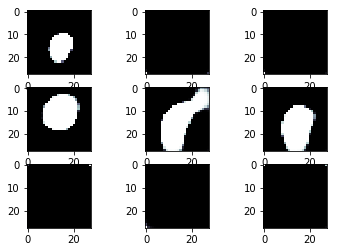

In [45]:
#10 epochs
img_row, img_col = 28, 28
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(predict[i].squeeze().reshape(img_row,img_col), cmap='bone')
# show the plot
plt.show()

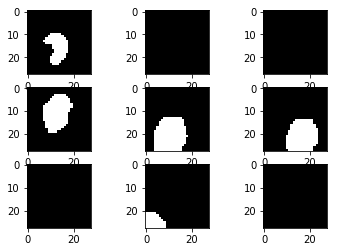

In [31]:
%matplotlib inline

img_row, img_col = 28, 28
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(y_patches_test[i].squeeze().reshape(img_row,img_col), cmap='bone')
# show the plot
plt.show()